In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from itertools import chain 
from random import sample
import scipy



import skimage
from skimage import io
import glob
from PIL import Image

import sklearn



##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:

## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print(all_xray_df.sample(3))


## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
#sample_df.sample(3)

             Image Index          Finding Labels  Follow-up #  Patient ID  \
56635   00014083_028.png  Emphysema|Pneumothorax           28       14083   
107726  00029110_000.png            Infiltration            0       29110   
1698    00000459_023.png              No Finding           23         459   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
56635            26              F            PA                 2522   
107726           48              M            PA                 2021   
1698             57              F            PA                 2544   

        Height]  OriginalImagePixelSpacing[x        y]  Unnamed: 11  
56635      2991                     0.143000  0.143000          NaN  
107726     2021                     0.194311  0.194311          NaN  
1698       3056                     0.139000  0.139000          NaN  


# 1. Exploring Patient demographic data

## 1.1 Number of pneumonia cases, diseases per patient, and comorbidities

In [10]:
# First thing to do it to split up findings labels into indivdual columns 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('Found {} unique labels'.format(len(all_labels)))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
sample_df.sample(5)

Found 15 unique labels


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1764,00009328_000.png,No Finding,0,9328,030Y,F,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4646,00023260_004.png,No Finding,4,23260,047Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
413,00002173_000.png,No Finding,0,2173,064Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2153,00011121_000.png,No Finding,0,11121,047Y,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3708,00018203_003.png,No Finding,3,18203,043Y,F,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now let us see the distribution of dieases in the dataset: 

[Text(0, 0.5, 'Number of Images with Label')]

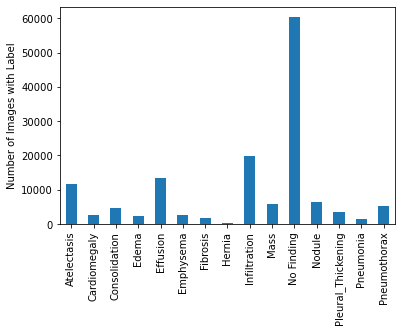

In [5]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [6]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

We see that the label "No finding" occurs in 53.8% of the data set; which mean only 46.2% of the data actaully have any findings. Only 1.2% of cases are labeled to have pneumonia; so rare it is only second to a hernia! The training data should be able to account for this by throwing away some negative cases. Test data should remain "real-world like". 


In [7]:
print("Number of pneumonia cases: {}".format(len(all_xray_df[all_xray_df.Pneumonia==1])))
print("Number of non-pneumonia cases: {}".format(len(all_xray_df) - len(all_xray_df[all_xray_df.Pneumonia==1])))

Number of pneumonia cases: 1431
Number of non-pneumonia cases: 110689


So the training data should have 1431 positive and 1431 negative cases

In [8]:
avg_col = all_xray_df[all_labels].sum(axis=1)
avg = avg_col.sum()/len(avg_col)

print("Number of diseases per patient: {}".format(avg))

Number of diseases per patient: 1.2623706742775598


Now let us look at the most-common comorbidities of pneumonia in the data set.

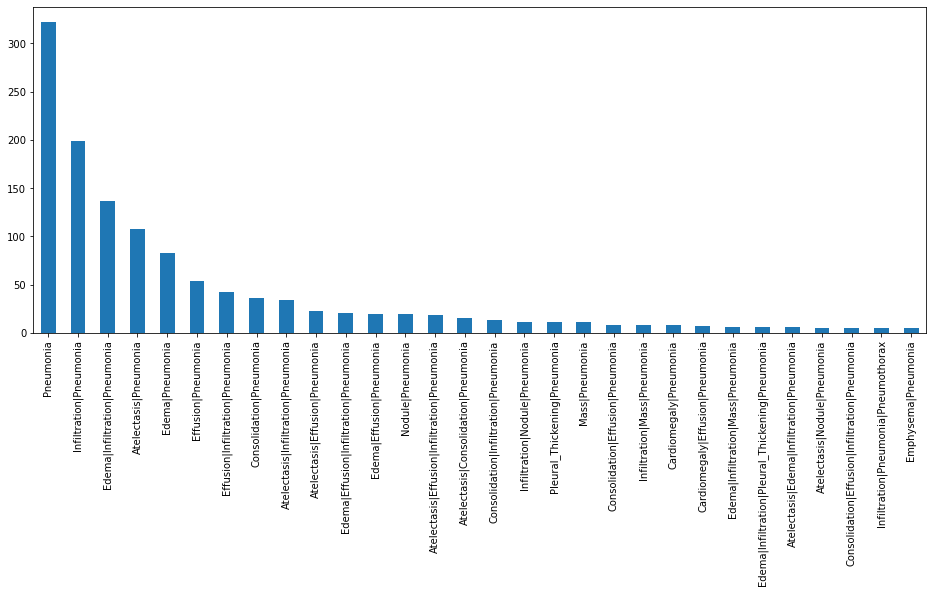

In [9]:
plt.figure(figsize=(16, 6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

The three most common comorbidites that occur with pneumonia are Infiltrations, Atelectasis, and Edema.

## 1.2 Exploration of age, gender, and patient position

(array([ 0.,  0.,  1.,  4.,  2.,  6.,  2.,  8.,  3., 13.,  2.,  5., 10.,
         8.,  9., 11., 16.,  8.,  8., 10., 10., 16., 20., 26., 24., 19.,
        24., 14., 21., 16., 20., 26., 23., 40., 25., 18., 17., 18., 27.,
        27., 26., 13., 19., 30., 23., 31., 23., 18., 34., 34., 25., 17.,
        28., 39., 25., 29., 34., 28., 36., 29., 34., 24., 22., 30., 19.,
        30., 34., 22., 20., 17., 10., 12., 11.,  6.,  4.,  5.,  8.,  6.,
         1.,  4.,  3.,  2.,  2.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  6

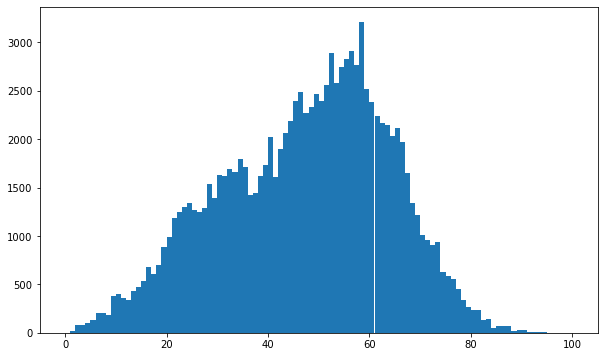

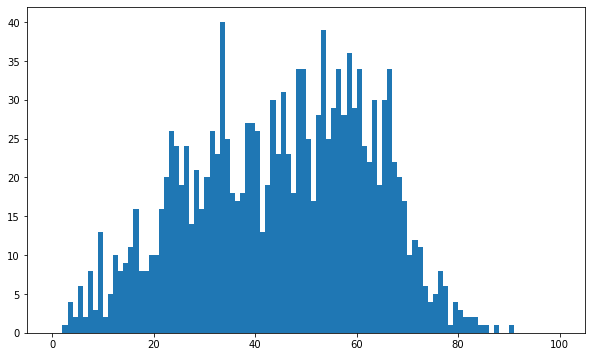

In [10]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], range=[0, 100], bins = 100)

plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Age'], range=[0, 100], bins = 100)

It appears as though the distribution of ages in the entire data set is very similar to that of those diagnosed with pneumoina. However, there is a slight increase in the number of cases which have pneumonia between the ages of 30 and 40 (with the peak being arround 55). 

(array([838.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

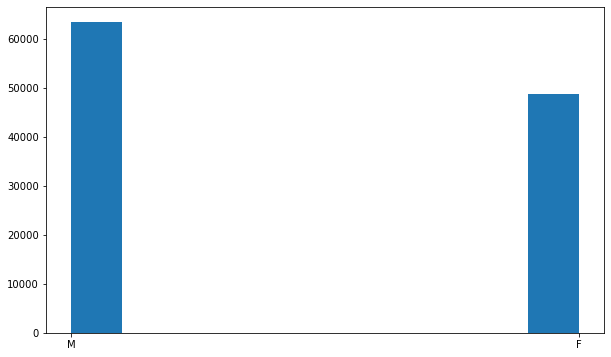

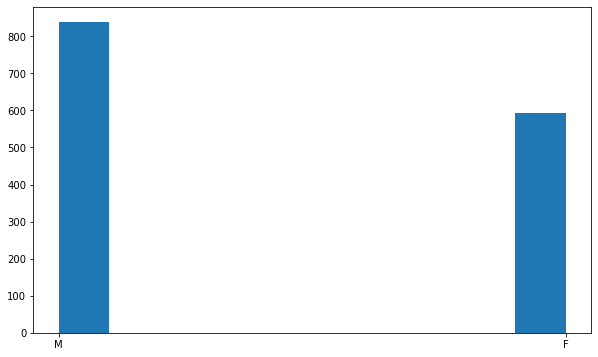

In [11]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Gender'])

plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'])

The gender distribution also seems similar across the entire data set vs. those with pneumonia. However, the disease does seem to effect men more than it does women (with an approximate difference of 28%). 

(array([801.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

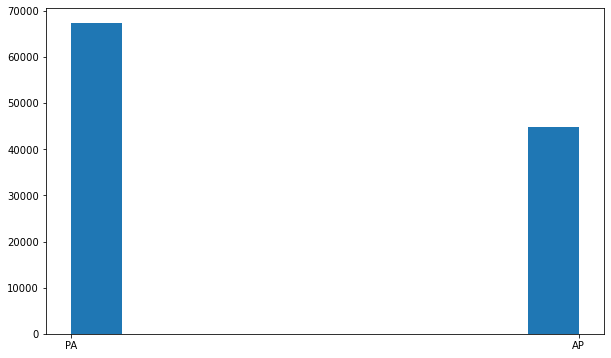

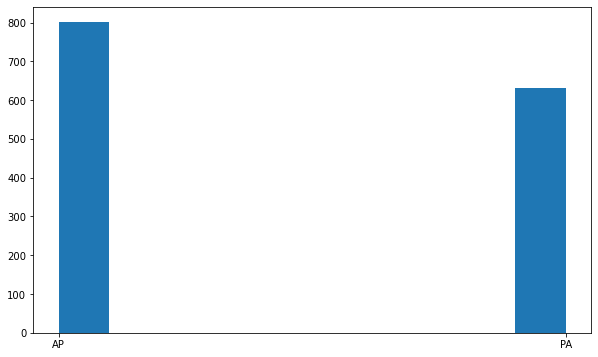

In [13]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['View Position'])

plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia == 1]['View Position'])

A similar result can be seen when analysed through the "View Position" attribute of the data set. AP view psoitons seem to have a higher positive diagnosis rate that PA positions.

Overall, the test data should also include these proportions, but we should consider training our model on an equal number of cases in any scenario. 

# 2. Pixel Level Assesment of Sample Data

## 2.1 Comparison of those with pneumonia vs. those without

First, for the cases that are positive for pneumonia

In [5]:
# First, we need to load the names of the files
file_names = sample_df[sample_df.Pneumonia == 1]["Image Index"]
file_names = file_names.sample(20) 

thresh = 50 

20


(array([4.24980e+04, 4.36130e+04, 4.57680e+04, 4.70770e+04, 0.00000e+00,
        4.84380e+04, 4.95960e+04, 5.13390e+04, 5.21490e+04, 0.00000e+00,
        5.31690e+04, 5.37610e+04, 5.44750e+04, 5.49350e+04, 0.00000e+00,
        5.60950e+04, 5.63990e+04, 5.75840e+04, 5.82150e+04, 0.00000e+00,
        5.97510e+04, 6.08650e+04, 6.12990e+04, 6.27560e+04, 0.00000e+00,
        6.32390e+04, 6.40820e+04, 6.41310e+04, 6.51920e+04, 0.00000e+00,
        6.59410e+04, 6.67650e+04, 6.80920e+04, 6.99020e+04, 0.00000e+00,
        7.10700e+04, 7.22430e+04, 7.29070e+04, 7.39750e+04, 0.00000e+00,
        7.38290e+04, 7.43130e+04, 7.52500e+04, 7.56260e+04, 0.00000e+00,
        7.60350e+04, 7.77740e+04, 7.92790e+04, 8.02470e+04, 0.00000e+00,
        8.29250e+04, 8.40560e+04, 8.63920e+04, 8.76440e+04, 0.00000e+00,
        8.99360e+04, 9.12480e+04, 9.19970e+04, 9.28210e+04, 0.00000e+00,
        9.32600e+04, 9.45640e+04, 9.51830e+04, 0.00000e+00, 9.67380e+04,
        9.69420e+04, 9.79960e+04, 9.97050e+04, 0.00

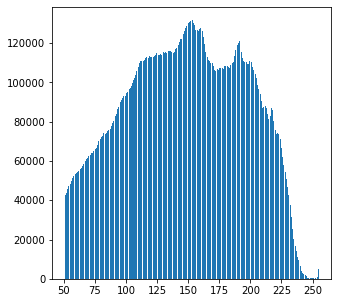

In [18]:

print(len(file_names))
intensities = []
idx = 1
l = len(file_names)
for name in file_names:
    print("Progress {:2.1%}".format(idx/l), end="\r")
    img = io.imread(glob.glob("/data/**/**/" + name)[0])
    mask = (img > thresh)
    data = img[mask].ravel()
    intensities.extend(data)
    idx = idx + 1

plt.figure(figsize=(5,5))
plt.hist(intensities, bins = 256)

    

We see that the peak here is about 150 with a relatively "normal" distribution around the peak. 

In [5]:
# First, we need to load the names of the files
file_names2 = sample_df[sample_df.Pneumonia == 0]["Image Index"]
files = file_names2.sample(20)


(array([ 56776.,  57563.,  57559.,  58400.,      0.,  60435.,  61164.,
         61757.,  62839.,      0.,  63187.,  64505.,  65244.,  66383.,
             0.,  66648.,  67069.,  67376.,  67650.,      0.,  69292.,
         70292.,  71772.,  72661.,      0.,  74659.,  75672.,  77656.,
         79004.,      0.,  79921.,  80567.,  81607.,  83196.,      0.,
         84429.,  86835.,  88597.,  89920.,      0.,  90399.,  91799.,
         92968.,  94544.,      0.,  95570.,  96380.,  97836.,  97662.,
             0.,  97193.,  97889.,  98519.,  99801.,      0., 101282.,
        103337., 105050., 104825.,      0., 105321., 104373., 104544.,
             0., 104495., 105230., 106191., 106419.,      0., 107568.,
        109568., 111853., 113239.,      0., 115259., 116151., 116273.,
        117148.,      0., 116935., 118229., 119168., 119785.,      0.,
        119907., 120976., 120675., 122509.,      0., 123592., 123408.,
        123366., 123016.,      0., 123204., 122595., 122513., 123607.,
      

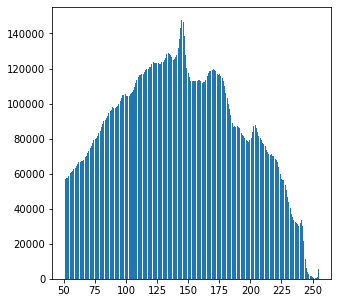

In [20]:
intensities2 = []
idx = 1
l = len(files)
for name in files:
    print("Progress {:2.1%}".format(idx/l), end="\r")
    img = io.imread(glob.glob("/data/**/**/" + name)[0])
    mask = (img > thresh)
    data = img[mask].ravel()
    intensities2.extend(data)
    idx = idx + 1

plt.figure(figsize=(5,5))
plt.hist(intensities2, bins = 256)

Comparing the intensity distributions of 50 cases with pneumonia vs. 50 cases without pneumonia, we see that there are much fewer pixels with higher intensity values in and around the 150-200 range, in the case where people don't have pneumonia, as compared to those with pneumonia. This leads me to beleive that x-rays of patients who have pneumonia must have more bright (not as light as bone) spots than x-rays of those who dont. 

Normalizing these values, we have: 

In [21]:
intensities = (intensities - np.mean(intensities))/(np.std(intensities))
intensities2 = (intensities2 - np.mean(intensities2))/(np.std(intensities2))


(array([ 56776.,  57563.,  57559.,  58400.,      0.,  60435.,  61164.,
         61757.,  62839.,      0.,  63187.,  64505.,  65244.,  66383.,
             0.,  66648.,  67069.,  67376.,  67650.,      0.,  69292.,
         70292.,  71772.,  72661.,      0.,  74659.,  75672.,  77656.,
         79004.,      0.,  79921.,  80567.,  81607.,  83196.,      0.,
         84429.,  86835.,  88597.,  89920.,      0.,  90399.,  91799.,
         92968.,  94544.,      0.,  95570.,  96380.,  97836.,  97662.,
             0.,  97193.,  97889.,  98519.,  99801.,      0., 101282.,
        103337., 105050., 104825.,      0., 105321., 104373., 104544.,
             0., 104495., 105230., 106191., 106419.,      0., 107568.,
        109568., 111853., 113239.,      0., 115259., 116151., 116273.,
        117148.,      0., 116935., 118229., 119168., 119785.,      0.,
        119907., 120976., 120675., 122509.,      0., 123592., 123408.,
        123366., 123016.,      0., 123204., 122595., 122513., 123607.,
      

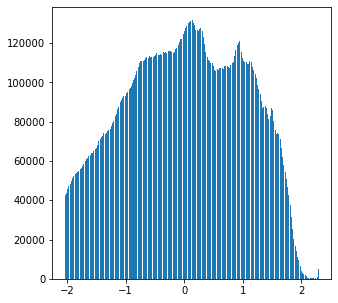

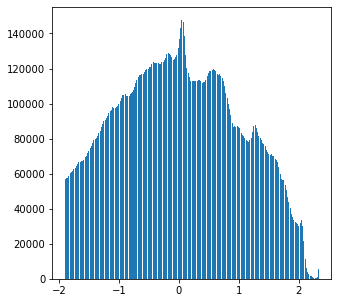

In [22]:
plt.figure(figsize=(5,5)) 
plt.hist(intensities, bins = 256)

plt.figure(figsize=(5,5))
plt.hist(intensities2, bins = 256)

The normalized plots confirm my above hypothesis. Namely, that x-rays of patients suffering from pneumonia have more bright regions than those without pneumonia. Let us see some exqamples to further confirm: 

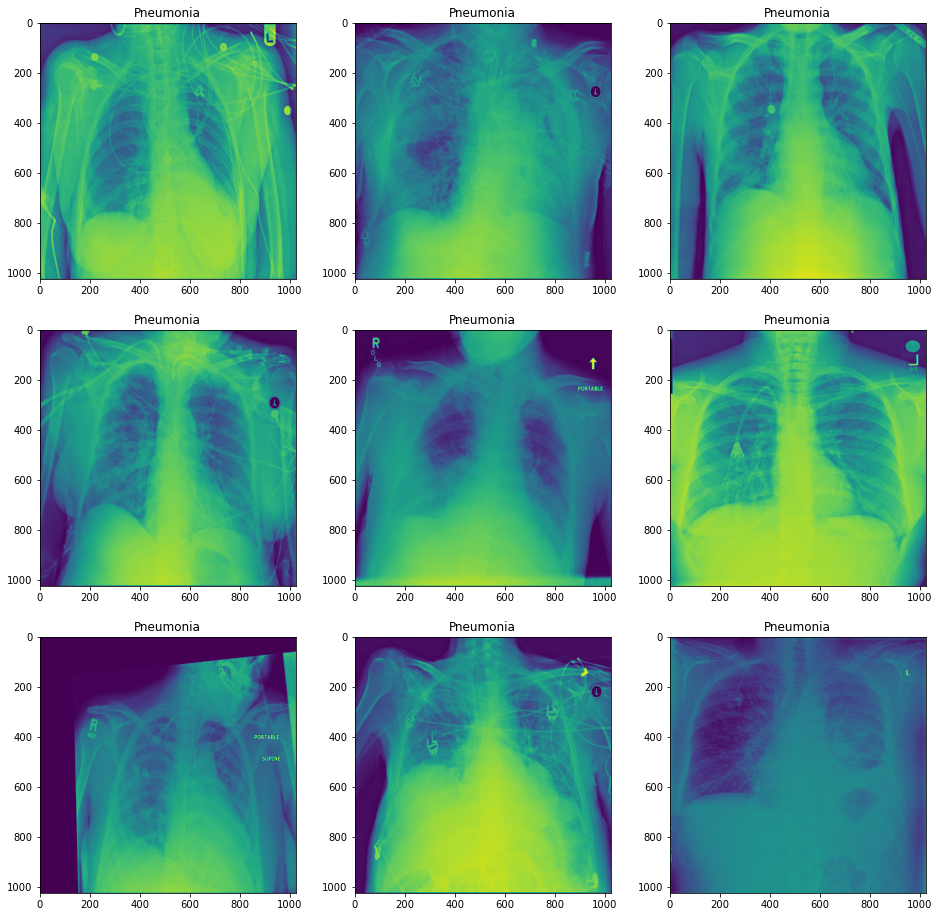

In [9]:
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = file_names.sample(9)
ind = 0 

for img, ax in zip(imgs, m_axs):
    img = io.imread(glob.glob("/data/**/**/" + img)[0])
    ax.imshow(img)
    ax.set_title("Pneumonia")

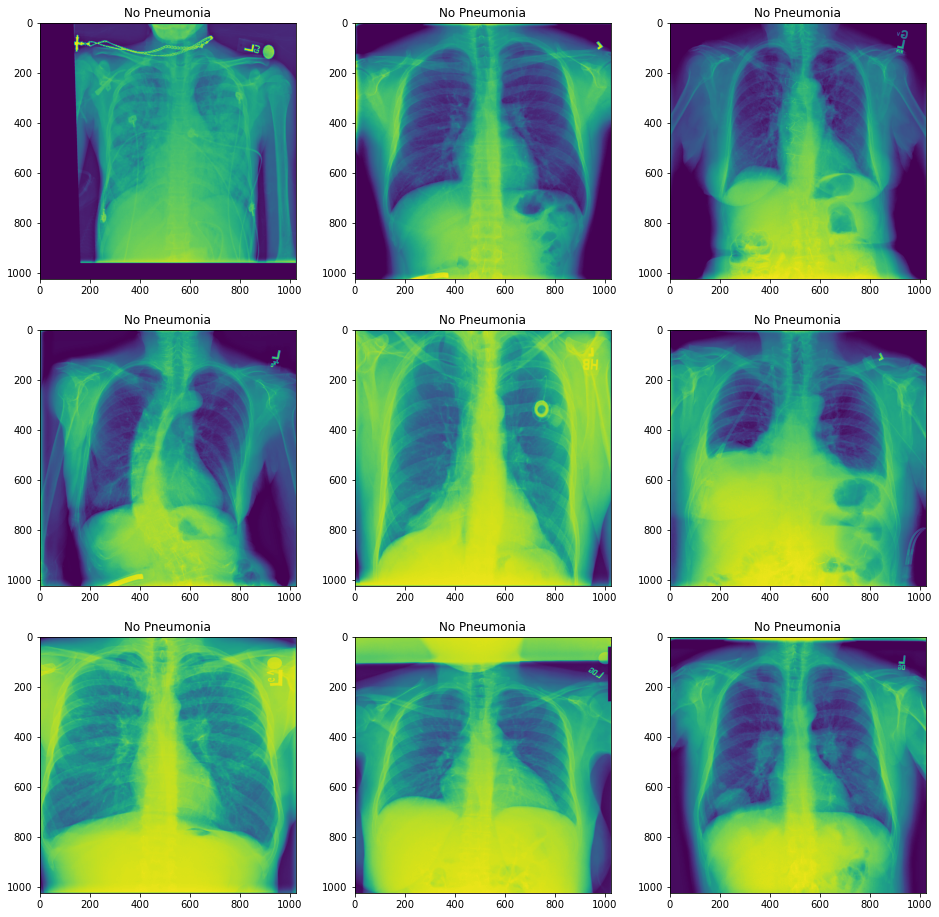

In [10]:
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs2 = file_names2.sample(9)
ind = 0 

for img, ax in zip(imgs2, m_axs):
    img = io.imread(glob.glob("/data/**/**/" + img)[0])
    ax.imshow(img)
    ax.set_title("No Pneumonia")

As suspected, the lungs of patients with pneumoia seem denser (and consequently brishter) than those without pneumonia. The deep learning model will ostnesibly use this feature the most to learn to classify images.

## 2.2 Comparison of pixel intensity values of those with pneumonia vs. those with other diseases

Let us compare pneumonia-positive cases with its most common co-morbidity: Infiltrations. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(array([ 44167.,  45376.,  46184.,  47603.,      0.,  48855.,  49283.,
         50123.,  51262.,      0.,  52168.,  53723.,  54528.,  55273.,
             0.,  56122.,  56987.,  58539.,  59538.,      0.,  60740.,
         62445.,  63332.,  65525.,      0.,  66979.,  68316.,  69849.,
         71105.,      0.,  71953.,  72791.,  73097.,  73961.,      0.,
         74783.,  75546.,  75617.,  77220.,      0.,  77898.,  79356.,
         79871.,  80230.,      0.,  81106.,  82756.,  84303.,  85797.,
             0.,  87746.,  88994.,  90819.,  92065.,      0.,  92994.,
         93140.,  93467.,  94875.,      0.,  95683.,  96591.,  97164.,
             0.,  98864., 100093., 101660., 103037.,      0., 104591.,
        106319., 107952., 109456.,      0., 110729., 111582., 112986.,
        113569.,      0., 113907., 113815., 113497., 112806.,      0.,
        113489., 114121., 114200., 115673.,      0., 116287., 117108.,
        117708., 119889.,      0., 121754., 123743., 127028., 130621.,
      

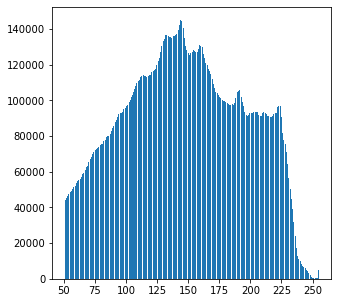

In [12]:
# Patients with pneumonia
file_names = sample_df[sample_df.Pneumonia == 1][sample_df.Infiltration == 0]["Image Index"]
file_names = file_names.sample(20) 
thresh = 50 
intensities = []
idx = 1
l = len(file_names)
for name in file_names:
    print("Progress {:2.1%}".format(idx/l), end="\r")
    img = io.imread(glob.glob("/data/**/**/" + name)[0])
    mask = (img > thresh)
    data = img[mask].ravel()
    intensities.extend(data)
    idx = idx + 1

plt.figure(figsize=(5,5))
plt.hist(intensities, bins = 256)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(array([ 46337.,  48535.,  49578.,  50815.,      0.,  52162.,  53896.,
         54879.,  55501.,      0.,  56677.,  57352.,  58793.,  60446.,
             0.,  61962.,  64123.,  65421.,  66548.,      0.,  67844.,
         69577.,  71255.,  72061.,      0.,  75086.,  76853.,  78691.,
         80699.,      0.,  81925.,  84551.,  86639.,  88435.,      0.,
         90055.,  91548.,  93511.,  96332.,      0.,  98221., 101834.,
        105808., 107839.,      0., 109515., 111298., 112723., 113920.,
             0., 113025., 112494., 112193., 113986.,      0., 115536.,
        117084., 117281., 118047.,      0., 117591., 117081., 117693.,
             0., 117938., 117219., 116060., 117950.,      0., 119360.,
        121795., 123360., 125096.,      0., 127827., 129896., 132477.,
        134878.,      0., 136706., 138915., 139612., 141028.,      0.,
        143014., 145547., 147869., 151194.,      0., 152714., 153095.,
        154849., 156305.,      0., 159629., 163829., 166845., 168000.,
      

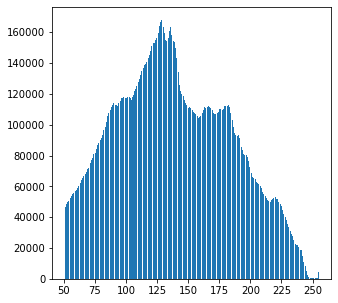

In [13]:
# Patients with infiltrations
file_names = sample_df[sample_df.Pneumonia == 0][sample_df.Infiltration == 1]["Image Index"]
file_names = file_names.sample(20) 
thresh = 50 
intensities = []
idx = 1
l = len(file_names)
for name in file_names:
    print("Progress {:2.1%}".format(idx/l), end="\r")
    img = io.imread(glob.glob("/data/**/**/" + name)[0])
    mask = (img > thresh)
    data = img[mask].ravel()
    intensities.extend(data)
    idx = idx + 1

plt.figure(figsize=(5,5))
plt.hist(intensities, bins = 256)

We see that the peak of patients with pneumonia is at a higher value (150 vs. approximately 135) and that patients with pneumonia have a greater number of brighter pxiels (in the 200 range in the scans).  Let us look for the patterns of patients with Edema:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(array([ 48175.,  50307.,  51360.,  53554.,      0.,  55384.,  56942.,
         58477.,  59862.,      0.,  60688.,  61927.,  64050.,  65815.,
             0.,  67722.,  69302.,  70868.,  73045.,      0.,  74493.,
         76433.,  77983.,  79875.,      0.,  81164.,  82848.,  84514.,
         85743.,      0.,  86278.,  86526.,  87064.,  87841.,      0.,
         89226.,  89366.,  90008.,  89757.,      0.,  90245.,  90663.,
         91042.,  90990.,      0.,  91087.,  91515.,  90712.,  91977.,
             0.,  92673.,  91976.,  91949.,  91525.,      0.,  92174.,
         93399.,  93601.,  93681.,      0.,  94967.,  95445.,  95482.,
             0.,  96182.,  96941.,  97751.,  97420.,      0.,  98584.,
         99150.,  98981.,  98660.,      0.,  99185., 100705., 102587.,
        103968.,      0., 106755., 109761., 111441., 114300.,      0.,
        116395., 118442., 120647., 124502.,      0., 128595., 130961.,
        132429., 132906.,      0., 133875., 134559., 135823., 137681.,
      

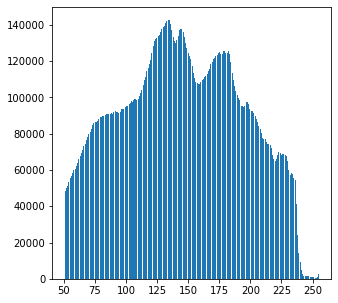

In [14]:
# Patients with infiltrations
file_names = sample_df[sample_df.Pneumonia == 0][sample_df.Atelectasis == 1]["Image Index"]
file_names = file_names.sample(20) 
thresh = 50 
intensities = []
idx = 1
l = len(file_names)
for name in file_names:
    print("Progress {:2.1%}".format(idx/l), end="\r")
    img = io.imread(glob.glob("/data/**/**/" + name)[0])
    mask = (img > thresh)
    data = img[mask].ravel()
    intensities.extend(data)
    idx = idx + 1

plt.figure(figsize=(5,5))
plt.hist(intensities, bins = 256)

Atelectases cases seem to have more pixels in the 175-200 range but fewer in the 200 and above range.. It seems to me that while cases of alectasis also show density in the lungs, it is not as prominant. 